# Basic Usage 
The SolGen package is a hierarchical simulation tool for photonic circuit. This notebook will cover the basic structure and the usage of the standalone package. Note that the syntax and logic is mainly built to imitate the [Nazca Design](https://nazca-design.org/) structure. 

## Getting started: a simple straight waveguide
Lets start with a very simple example, the transmission trough a straight waveguide. Although quite simple, this allows for some clear illustration if the code. 

In [60]:
import solver as sv

with sv.Solver() as mainsol:
    WG=sv.Waveguide(L=10.0, n=2.5)
    wg=WG.put()
    
    sv.Pin('a0').put(wg.pin['a0'])
    sv.Pin('b0').put(wg.pin['b0'])

With this code the main building block for realizing a simulation are put in place. In details:
1. A simulation cell mainsol is created (a solver object, in the syntax of the package).
2. A waveguide object (WG) with length 10 um and effective index 2.5 is created. At this point the simulation is still empty, since the model of the waveguide has been created but not placed. The package provides a few pre-defined models. Each models represent a component with a defined set of ports, indicated as named pin. In the case of the waveguide, the model has 2 ports, called a0 and b0.
3. The waveguide model is placed inside the simulation region with a put statement. This creates the instance (terminology borrowed form Nazca) wg. Since this is the first instance placed, the put is called with no argument. 
4. In order to be able to extract meaningful data from the simulation, the external ports should be defined. I this case, since only one waveguide is present, the two ports of the simulation coincide with the waveguide's ports.

In order to run the simulation and obtain data, a few more passage are needed:

In [61]:
MOD=mainsol.solve(wl=1.55)
T=MOD.get_T('a0','b0')
P=MOD.get_PH('a0','b0')
print(f'{T:.6} {P:.6}')

1.0 0.810734


The simulation is run by calling the method solve on the solver object. The input of the method can be a variable number of parameters previously defined. The parameter wl, which stands for wavelegnth, is defined for almost every model. 
The output of the solve method is a model object containing the scattering matrix of the defined system. 
Information about the transmission or reflection can be extracted with the dedicated methods `get_T` and `get_PH`. Both methods takes as input the names of two ports and yields the absolute transmission and the phase, respectively. 
In this case, we find that the transmission of a straight lossless waveguide is 1.0 (surprise!) and the phase acquired is 0.81 rad (modulus 2 pi, pretty meaningless in this case).

A more complete simulation could involve a wavelength sweep. This has to be done manually using a for loop

(Text(0.5, 1.0, 'Phase'),
 Text(0.5, 0, 'Wavelength [um]'),
 Text(0, 0.5, 'Phase [rad]'),
 None)

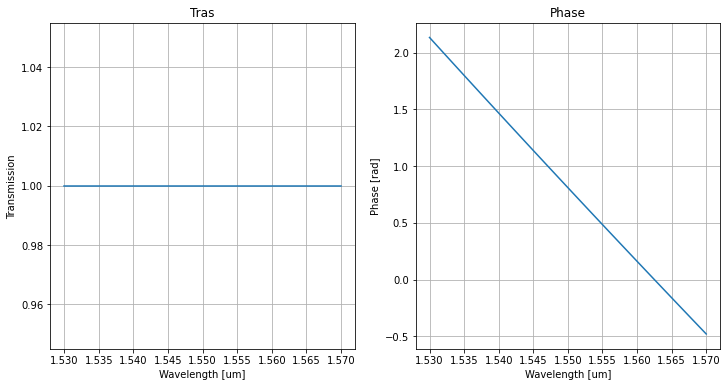

In [62]:
import numpy as np
import matplotlib.pyplot as plt

wl_list=np.linspace(1.53,1.57,101)
Tlist, Plist = [], []
for wl in wl_list:
    MOD=mainsol.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Plist.append(MOD.get_PH('a0','b0'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12.0, 6.0])    
ax1.plot(wl_list, Tlist)
ax1.set_title('Tras'), ax1.set_xlabel('Wavelength [um]'), ax1.set_ylabel('Transmission'), ax1.grid()
ax2.plot(wl_list, Plist)
ax2.set_title('Phase'), ax2.set_xlabel('Wavelength [um]'), ax2.set_ylabel('Phase [rad]'), ax2.grid()

Off course, a simulation with only one components inside is not very meaningful. In order to add more components and connect them, we will pass some additional parameters to the put statement. Here is the update example:

In [63]:
with sv.Solver() as mainsol:
    WG=sv.Waveguide(L=10.0, n=2.5)
    wg1=WG.put()
    wg2=WG.put('a0',wg1.pin['b0'])
    
    sv.Pin('a0').put(wg1.pin['a0'])
    sv.Pin('b0').put(wg2.pin['b0'])
    
mainsol.show_connections()
mainsol.show_free_pins()

Connection of solver:                 Solver object (id=140464777258128))
  (Structure (id=140464776665504) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140464776812384),    a0) <--> (Structure (id=140464776666848) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140464776812384),    b0)
Free pins of solver:                 Solver object (id=140464777258128))
  (Structure (id=140464776666848) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140464776812384),    a0) -->    a0
  (Structure (id=140464776665504) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140464776812384),    b0) -->    b0


In this case the second put statement add a new instance of the same waveguide, and connect the pin 'a0' of the new instance with the pin 'b0' of the already placed one. 
Rerunning the sweep thus results in:

(Text(0.5, 1.0, 'Phase'),
 Text(0.5, 0, 'Wavelength [um]'),
 Text(0, 0.5, 'Phase [rad]'),
 None)

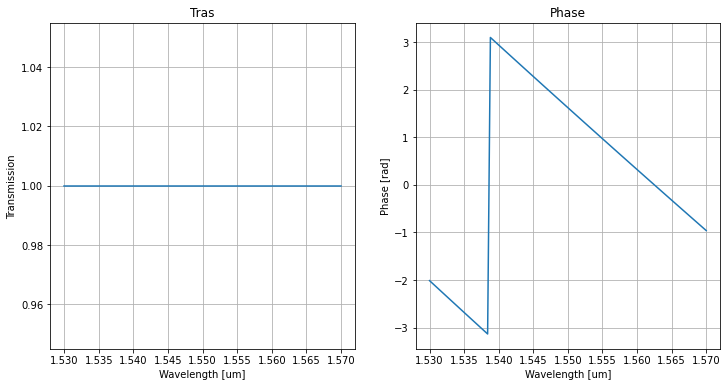

In [64]:
Tlist, Plist = [], []
for wl in wl_list:
    MOD=mainsol.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Plist.append(MOD.get_PH('a0','b0'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12.0, 6.0])    
ax1.plot(wl_list, Tlist)
ax1.set_title('Tras'), ax1.set_xlabel('Wavelength [um]'), ax1.set_ylabel('Transmission'), ax1.grid()
ax2.plot(wl_list, Plist)
ax2.set_title('Phase'), ax2.set_xlabel('Wavelength [um]'), ax2.set_ylabel('Phase [rad]'), ax2.grid()

As can be seen, the transmission is still 1, while the phase evolution is steeper, as expected from a longer waveguide. 

## Adding more: Add-Drop filter
As a second example, let's tackle something more meaningful: and add-drop filter based on ring resonator. For this, we will make use of another available model in the GenSol package: the directional coupler, our first 4 ports device.

For reason that will be apparent in the future, we will wrap the generation of the solver object inside a function. 

In [65]:
wl_list=np.linspace(1.53,1.57,201)

def add_drop(R,n,CR):
    with sv.Solver() as ADD_DROP:
        WG=sv.Waveguide(L=np.pi*R, n=n)
        BM=sv.BeamSplitter(ratio=CR)
        
        bm1=BM.put()
        wg1=WG.put('a0',bm1.pin['b1'])
        bm2=BM.put('b1',wg1.pin['b0'])
        wg2=WG.put('a0',bm2.pin['a1'])
        
        sv.connect(wg2.pin['b0'],bm1.pin['a1'])
        
        sv.Pin('a0').put(bm1.pin['a0'])
        sv.Pin('b0').put(bm1.pin['b0'])
        sv.Pin('a1').put(bm2.pin['a0'])
        sv.Pin('b1').put(bm2.pin['b0'])
    return ADD_DROP
        
ADD_DROP=add_drop(10.0, 2.5, 0.5)   

This simulation used 2 models. The first is the familiar waveguide. The other is a standard directional coupler, a four port (a0,a1,b0,b1) device. The light entering one the the a(b) port is split between the b(a) ports with a ratio defined at the creation of the model (default is 50/50).

A new function, namely the `connect`, is also used. This makes the connection between pins of already placed instances, which is useful when an instance has to be connected to more than one instance.

(<matplotlib.legend.Legend at 0x7fc0816b8670>,
 Text(0.5, 0, 'Wavelength [um]'),
 Text(0, 0.5, 'Transmisison'),
 None)

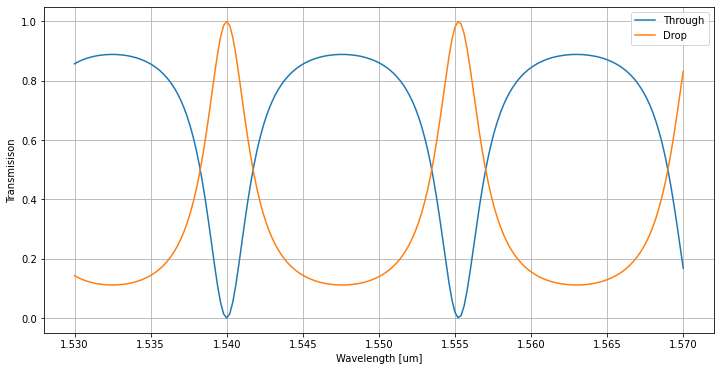

In [66]:
Tlist, Dlist = [], []
for wl in wl_list:
    MOD=ADD_DROP.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Dlist.append(MOD.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, Tlist, label='Through')
plt.plot(wl_list, Dlist, label='Drop')
plt.legend(), plt.xlabel('Wavelength [um]'), plt.ylabel('Transmisison'), plt.grid()

Now, by wrapping the definition of the add-drop inside a function, it is straightforward to change some parameters. For example, we could increase the radius.

(<matplotlib.legend.Legend at 0x7fc081645850>,
 Text(0.5, 0, 'Wavelength [um]'),
 Text(0, 0.5, 'Transmisison'),
 None)

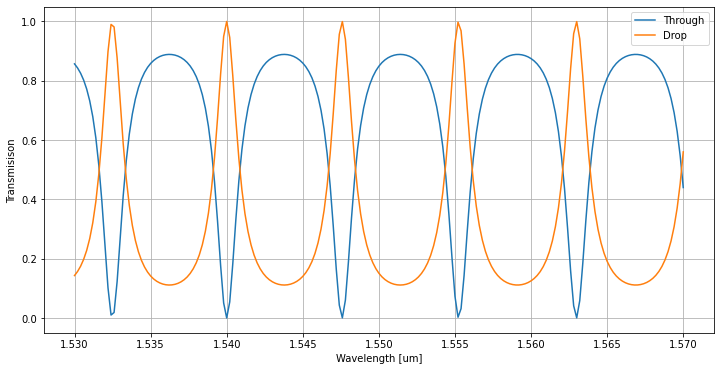

In [67]:
ADD_DROP=add_drop(20.0, 2.5, 0.5)  
Tlist, Dlist = [], []
for wl in wl_list:
    MOD=ADD_DROP.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Dlist.append(MOD.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, Tlist, label='Through')
plt.plot(wl_list, Dlist, label='Drop')
plt.legend(), plt.xlabel('Wavelength [um]'), plt.ylabel('Transmisison'), plt.grid()

Which leads to a decrease of the Free Spectral Range. Or, we could decrease the coupling ratio of the DC coupler from 50/50 to 10/90

(<matplotlib.legend.Legend at 0x7fc0815a8910>,
 Text(0.5, 0, 'Wavelength [um]'),
 Text(0, 0.5, 'Transmisison'),
 None)

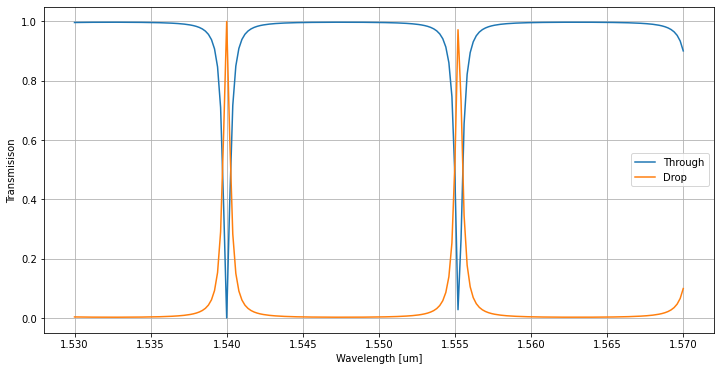

In [68]:
ADD_DROP=add_drop(10.0, 2.5, 0.1)  
Tlist, Dlist = [], []
for wl in wl_list:
    MOD=ADD_DROP.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Dlist.append(MOD.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, Tlist, label='Through')
plt.plot(wl_list, Dlist, label='Drop')
plt.legend(), plt.xlabel('Wavelength [um]'), plt.ylabel('Transmisison'), plt.grid()

which reduces the width of the resonance. 

## Going full power: Hierarchical design
An interesting features of the GenSol package is that the cells generated by the `with Solver` statement can be inserted as models in newly defined cells.

For example it would be really easy to define filter based on a double ring by reusing the function created for the single add-drop.

To do this, firstly we need to define two add-drop with different radii (for completeness, the spectra of the drop channels will also be plotted):


(<matplotlib.legend.Legend at 0x7fc081557970>,
 Text(0.5, 0, 'Wavelength [um]'),
 Text(0, 0.5, 'Transmisison'),
 None)

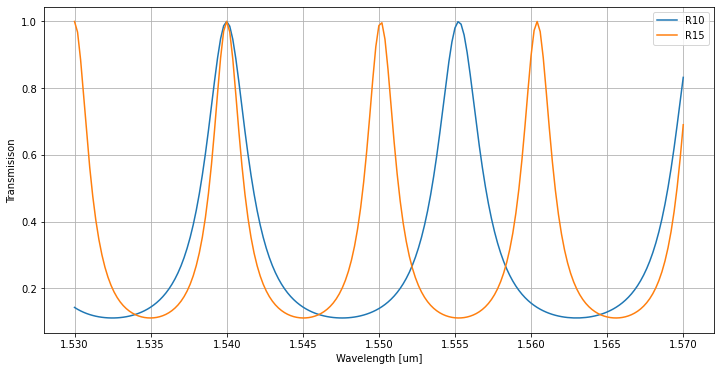

In [69]:
ADD_DROP_R10=add_drop(10.0, 2.5, 0.5)  
ADD_DROP_R15=add_drop(15.0, 2.5, 0.5)

D10list, D15list = [], []
for wl in wl_list:
    MOD10=ADD_DROP_R10.solve(wl=wl)
    MOD15=ADD_DROP_R15.solve(wl=wl)

    D10list.append(MOD10.get_T('a0','a1'))
    D15list.append(MOD15.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, D10list, label='R10')
plt.plot(wl_list, D15list, label='R15')
plt.legend(), plt.xlabel('Wavelength [um]'), plt.ylabel('Transmisison'), plt.grid()


Then, we define a new solver and we use the previosly defined ones as building blocks:

(<matplotlib.legend.Legend at 0x7fc08109dd90>,
 Text(0.5, 0, 'Wavelength [um]'),
 Text(0, 0.5, 'Transmisison'),
 None)

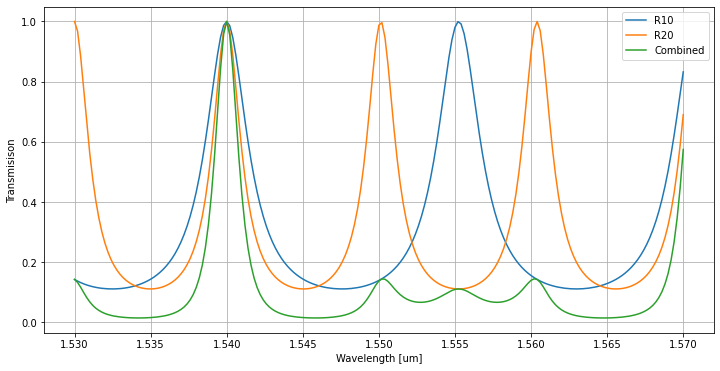

In [70]:
with sv.Solver() as FILTER:
    r1=ADD_DROP_R10.put()
    r2=ADD_DROP_R15.put('b0',r1.pin['a1'])
    
    sv.Pin('a0').put(r1.pin['a0'])
    sv.Pin('a1').put(r2.pin['a0'])
    sv.Pin('a2').put(r2.pin['a1'])
    sv.Pin('b0').put(r1.pin['b0'])
    sv.Pin('b1').put(r1.pin['b1'])
    sv.Pin('b2').put(r2.pin['b1'])
    
b0l,a1l,b2l=[], [], []
for wl in wl_list:
    MOD=FILTER.solve(wl=wl)

    b0l.append(MOD.get_T('a0','b0'))
    a1l.append(MOD.get_T('a0','a1'))
    b2l.append(MOD.get_T('a0','b2'))
    
plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, D10list, label='R10')
plt.plot(wl_list, D15list, label='R20')
plt.plot(wl_list, b2l, label='Combined')
plt.legend(), plt.xlabel('Wavelength [um]'), plt.ylabel('Transmisison'), plt.grid()